<a href="https://colab.research.google.com/github/AyeshaPervaiz15/-Real-World-Application6/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import accuracy_score
from google.colab import drive
drive.mount('./drive')
import os

# Path to your uploaded data folders
train_data_path = './drive/My Drive/train'
test_data_path = './/drive/My Drive/test'

# List contents of the train and test data folders
print("Contents of Train Data Folder:")
print(os.listdir(train_data_path))

print("\nContents of Test Data Folder:")
print(os.listdir(test_data_path))



# Data preparation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    "./drive/MyDrive/train",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)
valid_generator = valid_datagen.flow_from_directory(
    "./drive/MyDrive/validation",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)
test_generator = test_datagen.flow_from_directory(
    "./drive/MyDrive/test",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = valid_generator.samples // batch_size
# Model construction
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Model training
# Calculate the total number of samples in the training dataset
total_train_samples = len(train_generator.filenames)

# Calculate the number of batches needed to cover the entire training dataset
steps_per_epoch = total_train_samples // batch_size

# Ensure that at least one batch is used per epoch
if total_train_samples % batch_size != 0:
    steps_per_epoch += 1

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).
Contents of Train Data Folder:
['with_mask', 'without_mask']

Contents of Test Data Folder:
['with_mask', 'without_mask']
Found 1315 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 194 images belonging to 2 classes.
Epoch 1/10
21/21 [==============================] - 221s 11s/step - loss: 0.6631 - accuracy: 0.5970 - val_loss: 0.5469 - val_accuracy: 0.7969
Epoch 2/10
21/21 [==============================] - 161s 8s/step - loss: 0.4600 - accuracy: 0.8183 - val_loss: 0.2526 - val_accuracy: 0.9062
Epoch 3/10
21/21 [==============================] - 154s 7s/step - loss: 0.3574 - accuracy: 0.8570 - val_loss: 0.2742 - val_accuracy: 0.9062
Epoch 4/10
21/21 [==============================] - 166s 8s/step - loss: 0.3188 - accuracy: 0.8745 - val_loss: 0.2052 - val_accuracy: 0.9219
Epoch 5/10
21/21 [==============================] - 168s 8s/step - loss: 0

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from google.colab import files

# Function to detect face mask in a given image and return the labeled image
def detect_face_mask(image):
    # Check if the image is loaded successfully
    if image is None:
        print("Error: Unable to load image.")
        return None

    # Convert the image to RGB (OpenCV uses BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to match the input size of the model
    resized_image = cv2.resize(image_rgb, (224,224))

    # Preprocess the image
    normalized_image = resized_image / 255.0
    preprocessed_image = np.expand_dims(normalized_image, axis=0)

    # Predict whether the face is wearing a mask or not
    result = model.predict(preprocessed_image)

    # Label the image based on the prediction
    label = "No Mask" if result[0][0] > 0.5 else "Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # Draw the label on the image
    cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Convert the image back to BGR format for displaying with cv2_imshow
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Return the labeled image in BGR format
    return image_bgr

# Upload image file in Colab
uploaded = files.upload()

# Iterate over uploaded files
for filename in uploaded.keys():
    # Read the uploaded image
    image = cv2.imread(filename)

    # Detect face mask in the input image and display the labeled image
    labeled_image = detect_face_mask(image)

    # Check if the image is loaded successfully before displaying
    if labeled_image is not None:
        cv2_imshow(labeled_image)


4/4 [==============================] - 7s 2s/step


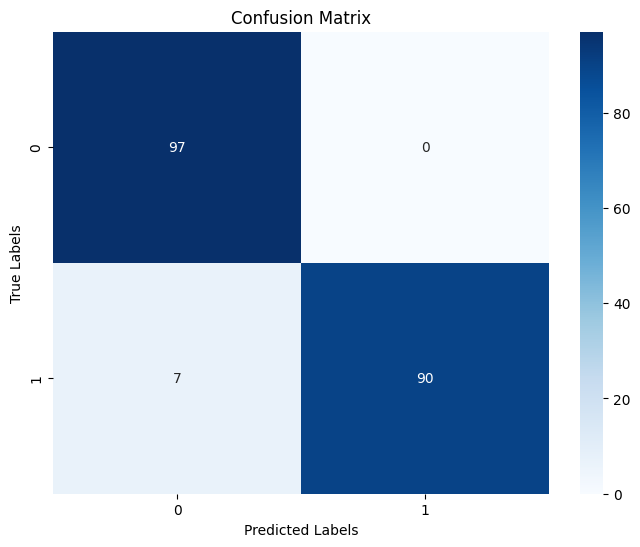

Accuracy: 0.9639175257731959


In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
y_true = test_generator.classes  # True labels
y_pred_prob = model.predict(test_generator)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Obtain confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate accuracy from confusion matrix
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy}")

# Calculate other performance metrics (precision, recall, F1-score) if needed

In [45]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model for face detection
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Function to load and preprocess images
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, (100, 100))
            images.append(img)
    return np.array(images)

# Load the dataset for training
X_train_face = load_images('./drive/My Drive/train/with_mask')
X_train_non_face = load_images('./drive/My Drive/train/without_mask')
y_train_face = np.ones(len(X_train_face))
y_train_non_face = np.zeros(len(X_train_non_face))

X_train = np.concatenate((X_train_face, X_train_non_face))
y_train = np.concatenate((y_train_face, y_train_non_face))

# Load the dataset for validation
X_val_face = load_images('./drive/My Drive/validation/with_mask')
X_val_non_face = load_images('./drive/My Drive/validation/without_mask')
y_val_face = np.ones(len(X_val_face))
y_val_non_face = np.zeros(len(X_val_non_face))

X_val = np.concatenate((X_val_face, X_val_non_face))
y_val = np.concatenate((y_val_face, y_val_non_face))

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# After training, you can save the model for future use
model.save('./face_detection_model.h5')


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 10, 10, 128)      

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import re

# Load pre-trained face detection and face mask detection models
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
mask_model = load_model('/content/face_detection_model.h5')

# Function to detect face mask in a given face image
def detect_face_mask(face_image):
    # Preprocess the face image
    resized_image = cv2.resize(face_image, (224, 224))
    normalized_image = resized_image.astype("float") / 255.0
    preprocessed_image = np.expand_dims(normalized_image, axis=0)

    # Predict whether the face is wearing a mask or not
    result = mask_model.predict(preprocessed_image)

    # Label the face based on the prediction
    label = "Mask" if result[0][0] > 0.5 else "No Mask"
    accuracy = result[0][0] if label == "Mask" else 1 - result[0][0]

    return label, accuracy

# Function to capture a photo using webcam in Google Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    # Extract base64 image data
    img_data = re.search(r'base64,(.*)', data).group(1)
    binary = b64decode(img_data)
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture a photo using webcam
photo_path = take_photo()

# Read the captured photo
frame = cv2.imread(photo_path)

# Convert frame to grayscale for face detection
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces in the frame
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

# Process each detected face
for (x, y, w, h) in faces:
    # Extract face region
    face_roi = frame[y:y+h, x:x+w]

    # Detect face mask
    label, accuracy = detect_face_mask(face_roi)

    # Draw bounding box and label with prediction accuracy
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
    text = f"{label}: {accuracy:.2f}"
    cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Print a message if no mask is detected
    if label == "No Mask":
        print("Warning: No mask detected!")

# Display the resulting frame
cv2.imshow('Face Mask Detection', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
